In [1]:
# 0. Settings
!pip install laion-clap
!pip install torch
!pip install torchvision
!pip install torchaudio
import laion_clap
import glob
import json
import torch
import numpy as np
import torchaudio
import tarfile
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import os
import glob
import tensorflow as tf
from tensorflow import keras
import pickle


In [2]:
keras.backend.clear_session()

# Define Classifier type

In [3]:
class_index_dict_path = 'label/drumsc.json'
column_name = 'Instrument' # 'genre', 'artist'

# Load Dataset

In [4]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
        print(type(values))
    return values

In [5]:
clap_audio_embeds = load_pickle('data/clap_audio_embeds.pkl')
train_audio_embeds = load_pickle('data/drum_audio_embeds.pkl')
train_ground_truth_idx = load_pickle('data/drum_ground_truth_idx.pkl')
test_audio_embeds = load_pickle('data/drum_drumtest60_audio_embeds.pkl')
test_ground_truth_idx = load_pickle('data/drum_drumtest60_ground_truth_idx.pkl')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>


In [6]:
train_ground_truth = np.array(train_ground_truth_idx)
test_ground_truth = np.array(test_ground_truth_idx)

In [7]:
print(clap_audio_embeds.shape,train_audio_embeds.shape,train_ground_truth.shape)
print(test_audio_embeds.shape,test_ground_truth.shape)
print(type(clap_audio_embeds),type(train_audio_embeds),type(train_ground_truth))

(50, 512) (1440, 512) (1440,)
(30, 512) (30,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Modeling (1) - Input : train_audio_embeds

In [15]:
import numpy as np
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

# Define the model
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=train_audio_embeds.shape[1]))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=2)

# Train the model
history = model.fit(train_audio_embeds, train_ground_truth, validation_split=0.1, epochs=50, batch_size=32, callbacks=[early_stop])


Epoch 1/50
41/41 [==============================] - 1s 7ms/step - loss: 0.4181 - accuracy: 0.8681 - val_loss: 1.3406 - val_accuracy: 0.8681
Epoch 2/50
41/41 [==============================] - 0s 4ms/step - loss: 0.1673 - accuracy: 0.9360 - val_loss: 1.0952 - val_accuracy: 0.9375
Epoch 3/50
41/41 [==============================] - 0s 4ms/step - loss: 0.1129 - accuracy: 0.9645 - val_loss: 0.9738 - val_accuracy: 0.8958
Epoch 4/50
41/41 [==============================] - 0s 5ms/step - loss: 0.0931 - accuracy: 0.9691 - val_loss: 0.8047 - val_accuracy: 0.9792
Epoch 5/50
41/41 [==============================] - 0s 4ms/step - loss: 0.0767 - accuracy: 0.9807 - val_loss: 0.6044 - val_accuracy: 0.9931
Epoch 6/50
41/41 [==============================] - 0s 4ms/step - loss: 0.1007 - accuracy: 0.9614 - val_loss: 0.5623 - val_accuracy: 0.9861
Epoch 7/50
41/41 [==============================] - 0s 4ms/step - loss: 0.0804 - accuracy: 0.9784 - val_loss: 0.4011 - val_accuracy: 1.0000
Epoch 8/50
41/41 [==

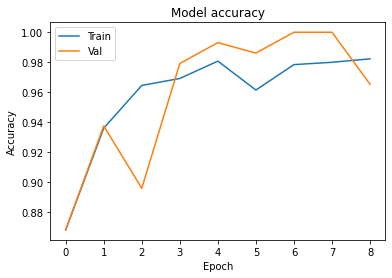

In [16]:
import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [17]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_audio_embeds, test_ground_truth)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


1/1 [==============================] - 0s 18ms/step - loss: 0.2218 - accuracy: 0.9667
Test loss: 0.22183384001255035
Test accuracy: 0.9666666388511658


# Modeling (2) - Input : train_audio_embeds + CLAP(ESC50)_audio_embeds

In [18]:
from tensorflow.keras.layers import concatenate

# Define input layers
input1 = Input(shape=(clap_audio_embeds.shape[1],))
input2 = Input(shape=(train_audio_embeds.shape[1],))

# Define first branch for clap_audio_embeds
x1 = Dense(1024, activation='relu')(input1)
x1 = BatchNormalization()(x1)
# x1 = Dense(512, activation='relu')(x1)
# x1 = Dropout(0.3)(x1)
# x1 = BatchNormalization()(x1)
# x1 = Dense(128, activation='relu')(x1)
# x1 = Dropout(0.3)(x1)
# x1 = BatchNormalization()(x1)
x1 = Dense(64, activation='relu')(x1)
x1 = Dropout(0.3)(x1)
x1 = BatchNormalization()(x1)

# Define second branch for train_audio_embeds
x2 = Dense(1024, activation='relu')(input2)
x2 = BatchNormalization()(x2)
# x2 = Dense(512, activation='relu')(x2)
# x2 = Dropout(0.3)(x2)
# x2 = BatchNormalization()(x2)
# x2 = Dense(128, activation='relu')(x2)
# x2 = Dropout(0.3)(x2)
# x2 = BatchNormalization()(x2)
x2 = Dense(64, activation='relu')(x2)
x2 = Dropout(0.3)(x2)
x2 = BatchNormalization()(x2)

# Concatenate the two branches
x = concatenate([x1, x2])

# Define output layer
output = Dense(6, activation='softmax')(x)

# Define the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=2)

# Train the model
history = model.fit([clap_audio_embeds, train_audio_embeds], train_ground_truth, validation_split=0.1, epochs=50, batch_size=16, callbacks=[early_stop])

Epoch 1/50
3/3 [==============================] - 1s 97ms/step - loss: 1.7052 - accuracy: 0.2889 - val_loss: 1.7651 - val_accuracy: 0.2000
Epoch 2/50
3/3 [==============================] - 0s 15ms/step - loss: 0.4953 - accuracy: 0.8222 - val_loss: 1.7214 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 14ms/step - loss: 0.2127 - accuracy: 0.9778 - val_loss: 1.6676 - val_accuracy: 1.0000
Epoch 4/50
3/3 [==============================] - 0s 15ms/step - loss: 0.1626 - accuracy: 0.9778 - val_loss: 1.6124 - val_accuracy: 1.0000
Epoch 5/50
3/3 [==============================] - 0s 15ms/step - loss: 0.1793 - accuracy: 0.9556 - val_loss: 1.5483 - val_accuracy: 1.0000


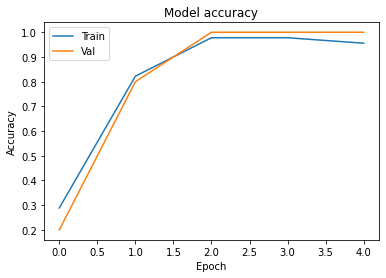

In [19]:
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [21]:
print(clap_audio_embeds.shape,train_audio_embeds.shape,train_ground_truth.shape)
print(clap_audio_embeds.shape,test_audio_embeds.shape,test_ground_truth.shape)

(50, 512) (1440, 512) (1440,)
(50, 512) (30, 512) (30,)


In [22]:
# Freeze the weights of the model
model.trainable = False

# Evaluate the model
test_loss, test_acc = model.evaluate([clap_audio_embeds, test_audio_embeds], test_ground_truth)
print('Test accuracy:', test_acc)


ValueError: Data cardinality is ambiguous:
  x sizes: 50, 30
  y sizes: 30
Make sure all arrays contain the same number of samples.